## Dataset preparation

In [1]:
import os
from typing import Callable, Tuple
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms

In [16]:
class DIV2KDataset(Dataset):
    def __init__(self, root: str, modification: Callable | None = None):
        self.root = root
        self.image_paths = [
            os.path.join(root, f) for f in os.listdir(root) if f.endswith(".png")
        ]
        self.transform = transforms.ToTensor()
        self.modification = modification

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor]:
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        img = img.astype(np.float32) / 255.0

        img = self.transform(img)

        if self.modification:
            modified_img = self.modification(img)
        else:
            modified_img = img

        return modified_img, img


In [17]:
def add_random_mask(
    img: torch.Tensor,
    mask_size: tuple[int, int] = (64, 64),
    num_patches: int = 1
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Generate a random mask and apply it to the image.
    """
    _, h, w = img.shape
    mask = torch.ones((1, h, w), dtype=img.dtype, device=img.device)

    for _ in range(num_patches):
        # Randomly select the top-left corner of each mask
        x = np.random.randint(0, w - mask_size[0])
        y = np.random.randint(0, h - mask_size[1])

        # Set mask region to zero (black)
        mask[:, y:y+mask_size[1], x:x+mask_size[0]] = 0

    # Set mask region to zero (black)
    mask[:, y:y+mask_size[1], x:x+mask_size[0]] = 0

    # Apply mask to the image
    masked_img = img * mask

    return masked_img, mask

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%env DIV2K_DATA_PATH=/content/drive/MyDrive/data/DIV2K

env: DIV2K_DATA_PATH=/content/drive/MyDrive/data/DIV2K


In [18]:
from torch.utils.data import DataLoader


dataset = DIV2KDataset(
    root=f"{os.getenv('DIV2K_DATA_PATH')}/DIV2K_train_HR",
    modification=lambda img: add_random_mask(img, num_patches=3),
)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

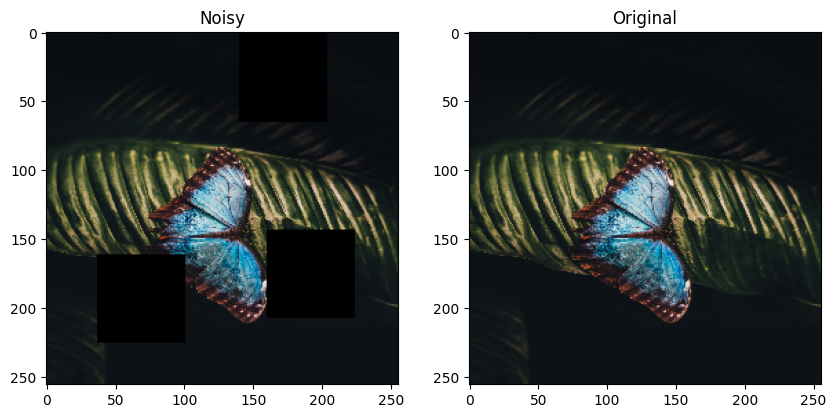

In [19]:
import matplotlib.pyplot as plt

x, y = next(iter(dataloader))
x_, mask = x
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(x_[0].permute(1, 2, 0))
axs[0].set_title("Noisy")
axs[1].imshow(y[0].permute(1, 2, 0))
axs[1].set_title("Original")
plt.show()

## Model definition

In [8]:
from torch import nn

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)


class Down(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(Down, self).__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.conv(x)
        pooled = self.pool(features)
        return features, pooled


class Up(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(Up, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:
        x = self.upconv(x)  # Upsample
        x = torch.cat((x, skip), dim=1)  # Concatenate with skip connection
        return self.conv(x)

In [10]:
class InpaintingUNet(nn.Module):
    """U-Net model for image inpainting"""
    def __init__(self, in_channels: int = 4, out_channels: int = 3):
        super(InpaintingUNet, self).__init__()

        self.down1 = Down(in_channels, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)

        self.bottleneck = ConvBlock(512, 1024)

        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the U-Net.
        :param x: Masked image (B, 3, H, W)
        :param mask: Binary mask (B, 1, H, W) where 0 = missing pixels, 1 = valid pixels
        """
        # Concatenate the mask with the input image along the channel dimension
        x = torch.cat((x, mask), dim=1)

        # Encoder (Downsampling)
        skip1, d1 = self.down1(x)
        skip2, d2 = self.down2(d1)
        skip3, d3 = self.down3(d2)
        skip4, d4 = self.down4(d3)

        # Bottleneck
        bottleneck = self.bottleneck(d4)

        # Decoder (Upsampling with Skip Connections)
        up1 = self.up1(bottleneck, skip4)
        up2 = self.up2(up1, skip3)
        up3 = self.up3(up2, skip2)
        up4 = self.up4(up3, skip1)

        return self.final_conv(up4)

## Training

In [20]:
from tqdm import tqdm
import torch.optim as optim

In [21]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)

In [22]:
model = InpaintingUNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = torch.compile(model)
model = model.to(device)

In [23]:
def train(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.MSELoss,
    optimizer: optim.Adam,
    device:str,
    epochs: int = 5
) -> nn.Module:
    model.train()
    scaler = torch.amp.GradScaler()  # Enables mixed precision training

    for epoch in range(epochs):
        epoch_loss = 0

        for imgs_with_masks, clean_imgs in tqdm(dataloader):
            masked_imgs, masks = imgs_with_masks
            masked_imgs, masks, clean_imgs = masked_imgs.to(device), masks.to(device), clean_imgs.to(device)

            optimizer.zero_grad()

            with torch.amp.autocast(device_type=device_type):  # Automatically uses float16
                outputs = model(masked_imgs, masks)
                loss = criterion(outputs, clean_imgs)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader):.4f}")

    return model

In [24]:
model = train(model, dataloader, criterion, optimizer, device, epochs=5)

100%|██████████| 50/50 [02:50<00:00,  3.42s/it]


Epoch 1/5, Loss: 0.0431


100%|██████████| 50/50 [01:43<00:00,  2.06s/it]


Epoch 2/5, Loss: 0.0162


100%|██████████| 50/50 [01:40<00:00,  2.01s/it]


Epoch 3/5, Loss: 0.0118


100%|██████████| 50/50 [01:40<00:00,  2.02s/it]


Epoch 4/5, Loss: 0.0108


100%|██████████| 50/50 [01:40<00:00,  2.01s/it]

Epoch 5/5, Loss: 0.0101


In [25]:
%env MODEL_CHECKPOINTS_PATH=/content/drive/MyDrive/studia/sigk/model_checkpoints

env: MODEL_CHECKPOINTS_PATH=/content/drive/MyDrive/studia/sigk/model_checkpoints


In [26]:
checkpoints_path = os.getenv("MODEL_CHECKPOINTS_PATH")

In [27]:
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
torch.save(model, f"{checkpoints_path}/InpaintingUNet_{timestamp}.pt")

In [28]:
eval_dataset = DIV2KDataset(
    root=f"{os.getenv('DIV2K_DATA_PATH')}/DIV2K_valid_HR",
    modification=lambda img: add_random_mask(img, num_patches=3),
)
eval_dataloader = DataLoader(eval_dataset, batch_size=8, shuffle=True)

In [29]:
import matplotlib.pyplot as plt

def visualize_inpainting(model, dataloader, device, num_images=4):
    model.eval()

    with torch.no_grad():
        imgs_with_masks, clean_imgs = next(iter(dataloader))
        masked_imgs, masks = imgs_with_masks
        masked_imgs, masks, clean_imgs = masked_imgs.to(device), masks.to(device), clean_imgs.to(device)

        inpainted_imgs = model(masked_imgs, masks).cpu().permute(0, 2, 3, 1).numpy()

    masked_imgs = masked_imgs.cpu().permute(0, 2, 3, 1).numpy()
    clean_imgs = clean_imgs.cpu().permute(0, 2, 3, 1).numpy()

    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 3))

    for i in range(num_images):
        axes[i, 0].imshow(masked_imgs[i])
        axes[i, 0].set_title("Masked Input")

        axes[i, 1].imshow(inpainted_imgs[i])
        axes[i, 1].set_title("Inpainted Output")

        axes[i, 2].imshow(clean_imgs[i])
        axes[i, 2].set_title("Ground Truth")

        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()


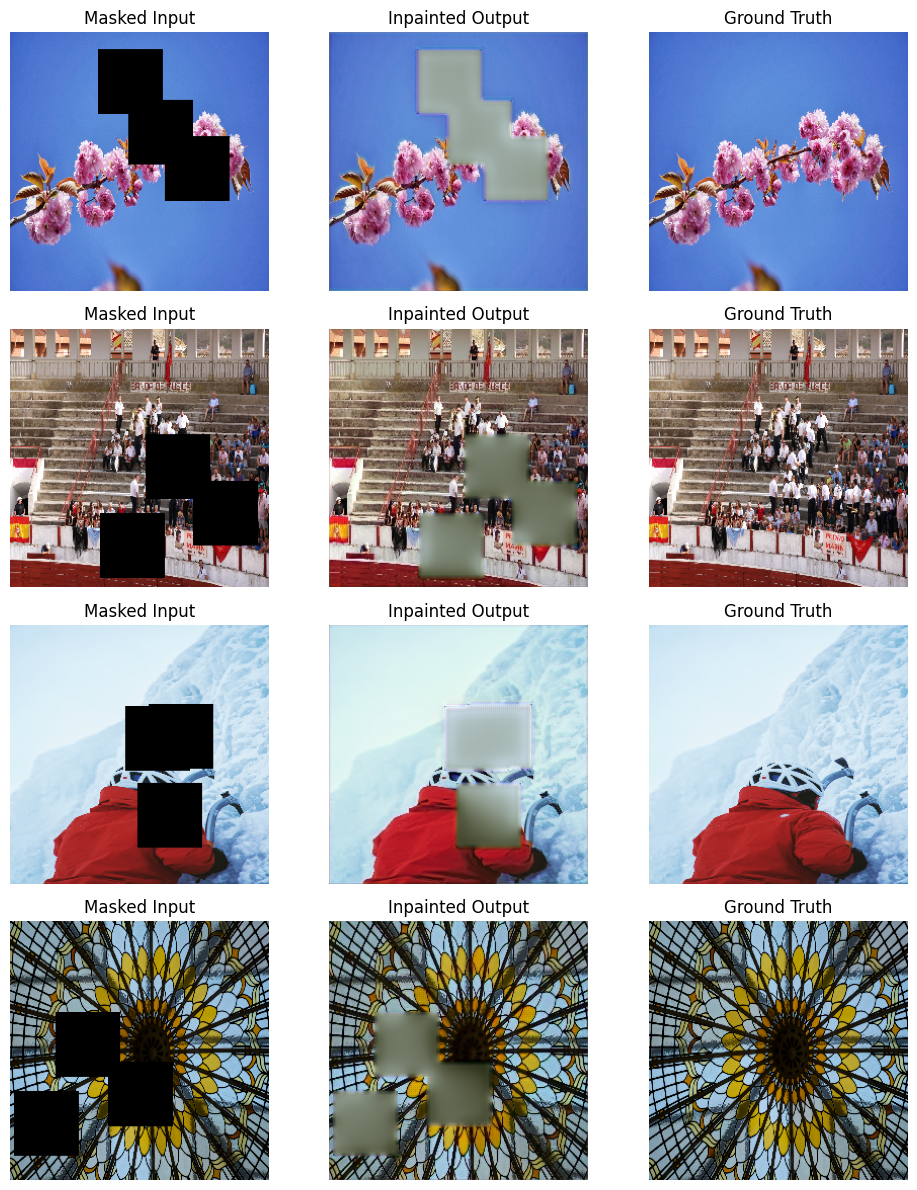

In [30]:
visualize_inpainting(model, eval_dataloader, device)